In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score

In [2]:
data = pd.read_csv('emp_abs.csv')
data.head()

,EmployeeNumber,Surname,GivenName,Gender,City,JobTitle,DepartmentName,StoreLocation,Division,Age,LengthService,AbsentHours,BusinessUnit
0,1,Gutierrez,Molly,F,Burnaby,Baker,Bakery,Burnaby,Stores,32.028816,6.018478,36.577306,Stores
1,2,Hardwick,Stephen,M,Courtenay,Baker,Bakery,Nanaimo,Stores,40.320902,5.532445,30.165072,Stores
2,3,Delgado,Chester,M,Richmond,Baker,Bakery,Richmond,Stores,48.822047,4.389973,83.807798,Stores
3,4,Simon,Irene,F,Victoria,Baker,Bakery,Victoria,Stores,44.599357,3.081736,70.020165,Stores
4,5,Delvalle,Edward,M,New Westminster,Baker,Bakery,New Westminster,Stores,35.697876,3.619091,0.000000,Stores


In [3]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8336 entries, 0 to 8335
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   EmployeeNumber  8336 non-null   int64  
 1   Surname         8336 non-null   object 
 2   GivenName       8336 non-null   object 
 3   Gender          8336 non-null   object 
 4   City            8336 non-null   object 
 5   JobTitle        8336 non-null   object 
 6   DepartmentName  8336 non-null   object 
 7   StoreLocation   8336 non-null   object 
 8   Division        8336 non-null   object 
 9   Age             8336 non-null   float64
 10  LengthService   8336 non-null   float64
 11  AbsentHours     8336 non-null   float64
 12  BusinessUnit    8336 non-null   object 
dtypes: float64(3), int64(1), object(9)
memory usage: 846.8+ KB
None


In [4]:
print(data.describe())

       EmployeeNumber          Age  LengthService  AbsentHours
count     8336.000000  8336.000000    8336.000000  8336.000000
mean      4168.500000    42.007086       4.782910    61.283978
std       2406.540255     9.939798       2.462990    49.038365
min          1.000000     3.504743       0.012098     0.000000
25%       2084.750000    35.298748       3.575892    19.127590
50%       4168.500000    42.114924       4.600248    56.005808
75%       6252.250000    48.666943       5.623922    94.284692
max       8336.000000    77.938003      43.735239   272.530123


In [5]:
data_cleaned = data.drop(columns=['EmployeeNumber','Surname','GivenName'])

In [6]:
numeric_columns = ['Age', 'LengthService', 'AbsentHours']
plt.figure(figsize=(15, 5))

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

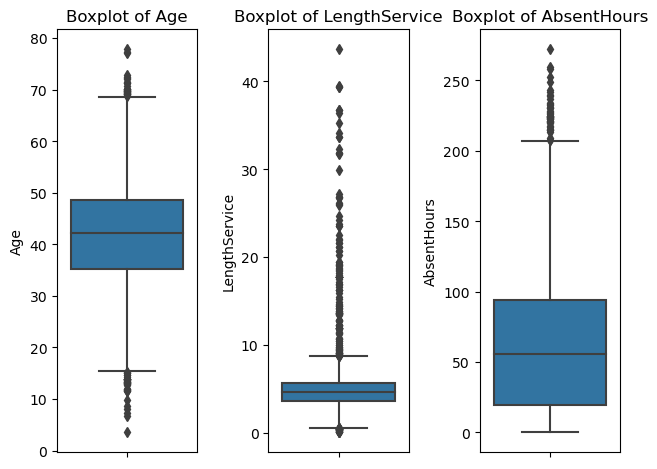

In [7]:
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(y=data_cleaned[col])
    plt.title(f'Boxplot of {col}')
    
plt.tight_layout()
plt.show()

In [8]:
def identify_outliers(df, columns):
    outlier_indices = []
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)].index
        outlier_indices.extend(outliers)
    outlier_indices = list(set(outlier_indices))  # Remove duplicates
    return df.loc[outlier_indices]

In [9]:
numeric_columns = ['Age', 'LengthService', 'AbsentHours']
outliers = identify_outliers(data_cleaned, numeric_columns)
print(outliers)

     Gender         City                    JobTitle        DepartmentName  \
513       M   Abbotsford                     Cashier      Customer Service   
7685      M     Kamloops                     Cashier      Customer Service   
6         M    Vancouver            Accounting Clerk            Accounting   
5127      F    Vancouver                     Cashier      Customer Service   
518       F    Vancouver                     Trainer              Training   
...     ...          ...                         ...                   ...   
501       F    Vancouver                     Trainer              Training   
6133      F  Fort Nelson                Dairy Person                 Dairy   
504       F    Vancouver                     Trainer              Training   
3581      F      Nanaimo               Produce Clerk               Produce   
1534      M     Richmond  Accounts Receiveable Clerk  Accounts Receiveable   

     StoreLocation              Division        Age  LengthServ

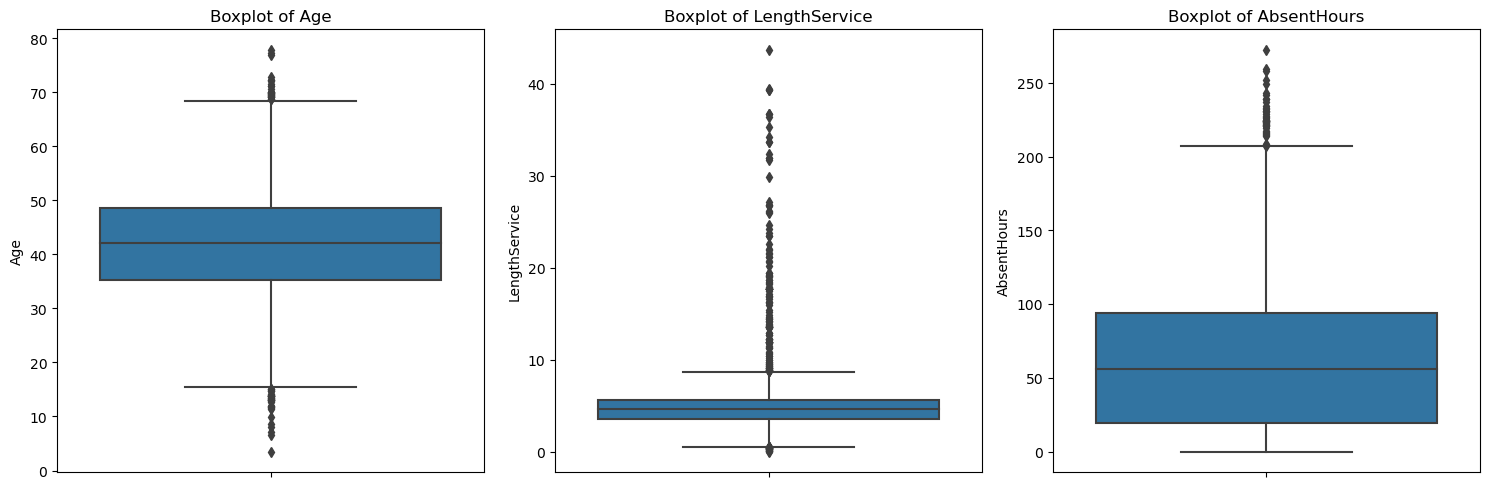

In [10]:
plt.figure(figsize=(15, 5))
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(y=data_cleaned[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

In [11]:
def remove_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

numeric_columns = ['Age','LengthService','AbsentHours']
data_no_outliers = remove_outliers(data_cleaned, numeric_columns)

In [12]:
categorical_columns = ['Gender', 'City', 'JobTitle', 'DepartmentName', 'StoreLocation', 'Division', 'BusinessUnit']
data_encoded = pd.get_dummies(data_no_outliers, columns=categorical_columns, drop_first=True)

In [13]:
X = data_encoded.drop(columns=['AbsentHours'])
y = data_encoded['AbsentHours']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
mlr = LinearRegression()
mlr.fit(X_train, y_train)

LinearRegression()

In [16]:
y_pred_mlr = mlr.predict(X_test)

In [17]:
mse_mlr = mean_squared_error(y_test, y_pred_mlr)
rmse_mlr = mean_squared_error(y_test, y_pred_mlr, squared=False)
r2_mlr = r2_score(y_test, y_pred_mlr)

In [18]:
print("MLR - Mean Squared Error:", mse_mlr)
print("MLR - Root Mean Squared Error:", rmse_mlr)
print("MLR - R-Squared:", r2_mlr)

MLR - Mean Squared Error: 3.589401206555003e+20
MLR - Root Mean Squared Error: 18945715100.13545
MLR - R-Squared: -1.559862550505914e+17


In [19]:
rfr = RandomForestRegressor(random_state=42)
rfr.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [20]:
y_pred_rfr = rfr.predict(X_test)

In [21]:
mse_rfr = mean_squared_error(y_test, y_pred_rfr)
rmse_rfr = mean_squared_error(y_test, y_pred_rfr, squared=False)
r2_rfr = r2_score(y_test, y_pred_rfr)

In [22]:
print("RFR - Mean Squared Error:", mse_rfr)
print("RFR - Root Mean Squared Error:", rmse_rfr)
print("RFR - R-Squared:", r2_rfr)

RFR - Mean Squared Error: 610.5678062338818
RFR - Root Mean Squared Error: 24.709670297959903
RFR - R-Squared: 0.7346627471597499


In [23]:
pca = PCA(n_components=0.95)  # retain 95% of variance
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [24]:
mlr_pca = LinearRegression()
mlr_pca.fit(X_train_pca, y_train)

LinearRegression()

In [25]:
y_pred_mlr_pca = mlr_pca.predict(X_test_pca)

In [26]:
mse_mlr_pca = mean_squared_error(y_test, y_pred_mlr_pca)
rmse_mlr_pca = mean_squared_error(y_test, y_pred_mlr_pca, squared=False)
r2_mlr_pca = r2_score(y_test, y_pred_mlr_pca)

In [27]:
print("MLR with PCA - Mean Squared Error:", mse_mlr_pca)
print("MLR with PCA - Root Mean Squared Error:", rmse_mlr_pca)
print("MLR with PCA - R-Squared:", r2_mlr_pca)

MLR with PCA - Mean Squared Error: 664.6976993826223
MLR with PCA - Root Mean Squared Error: 25.781731892613852
MLR with PCA - R-Squared: 0.7111392711461433


In [28]:
rfr_pca = RandomForestRegressor(random_state=42)
rfr_pca.fit(X_train_pca, y_train)

RandomForestRegressor(random_state=42)

In [29]:
y_pred_rfr_pca = rfr_pca.predict(X_test_pca)

In [30]:
mse_rfr_pca = mean_squared_error(y_test, y_pred_rfr_pca)
rmse_rfr_pca = mean_squared_error(y_test, y_pred_rfr_pca, squared=False)
r2_rfr_pca = r2_score(y_test, y_pred_rfr_pca)

In [31]:
print("RFR with PCA - Mean Squared Error:", mse_rfr_pca)
print("RFR with PCA - Root Mean Squared Error:", rmse_rfr_pca)
print("RFR with PCA - R-Squared:", r2_rfr_pca)

RFR with PCA - Mean Squared Error: 732.7714224188013
RFR with PCA - Root Mean Squared Error: 27.06975105941688
RFR with PCA - R-Squared: 0.6815561610040589


In [32]:
feature_importances = rfr.feature_importances_
features = X.columns
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

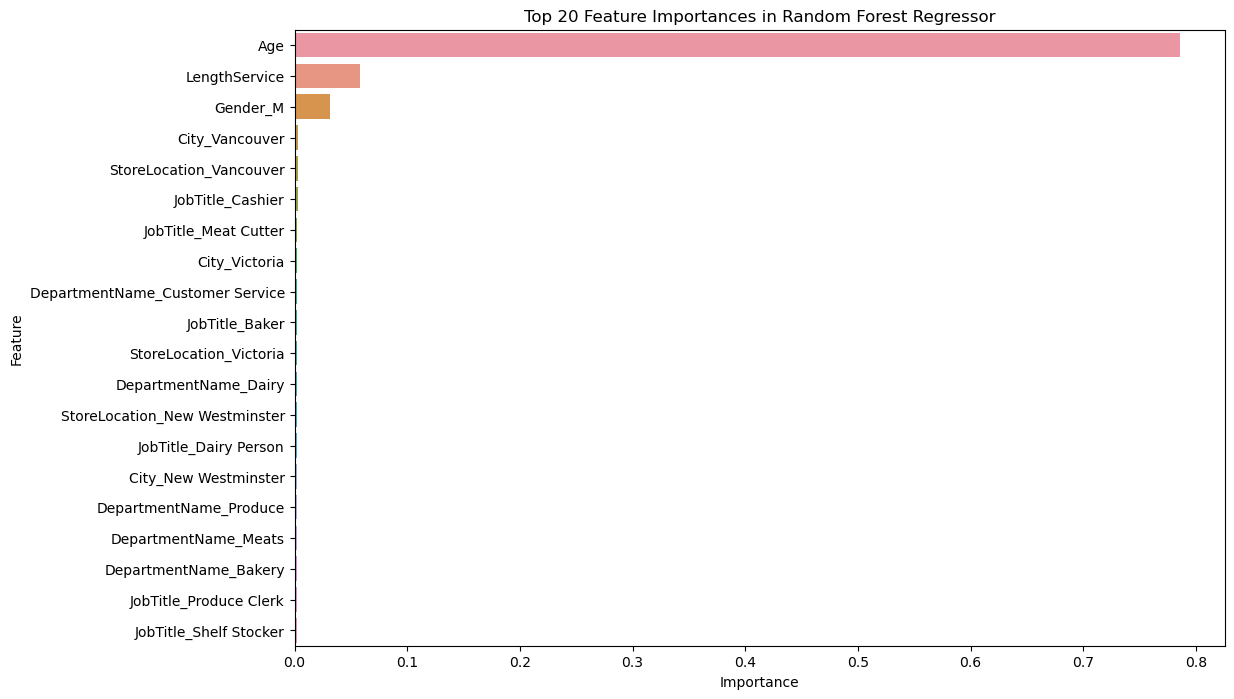

In [33]:
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20))
plt.title('Top 20 Feature Importances in Random Forest Regressor')
plt.show()